<h1 style="text-align: center;">Binary Classification of Rice Varieties</h1>
<h3 style="text-align: center;">By Trevor Portillo</h3>
<h4 style="text-align: center;">ITSC - 3156</h4>

### Introduction:
This project focuses on applying machine learning algorithms to classify rice varieties from grayscale images. The dataset contains images of five rice varieties however this project will focus on just two: Karacadag and Arborio. The goal is to build a machine learning pipeline to preprocess the images, extract features, and classify them into one of the two categories. Logistic Regression and K-Nearest Neighbors (KNN) are used as the two algorithms for classification.

Machine learning is widely used in agriculture to automate quality control and variety identification. The motivation for this project is to explore how well traditional machine learning algorithms perform on this task using a publicly available dataset. The dataset consists of **75,000** grayscale images, **resized to 128x128 pixels**, which ensures sufficient complexity and features.

### About the Imports:

- **os** and **cv2**: For file management and image processing.
- **numpy** and **pandas**: For numerical computations and data handling.
- **matplotlib.pyplot**: For data visualization.
- **sklearn**: Provides tools for model training, evaluation, and hyperparameter tuning.
- **tensorflow.keras.preprocessing.image**: For data augmentation.


In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.model_selection import cross_val_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV

#### About the Data:
- The dataset contains images of five rice varieties: **Karacadag, Arborio, Basmati, Ipsala, and Jasmine**
- For our purposes we decided to look at two of them, **Karacadag and Arborio** 
- Each image is a **grayscale representation** of a rice grain, with dimensions standardized to **128x128 pixels** 
- There are **15,000** samples in each class **(30,000 total)** ensuring that the dataset is large enough to challenge the models

In [2]:
data_dir = "C:\\Users\\newtr\\OneDrive\\Desktop\\FinalProject"
categories = ["Karacadag", "Arborio"]

# Initialize data and labels
data = []
labels = []

# Loop through each class folder
for category in categories:
    folder_path = os.path.join(data_dir, category)
    class_label = categories.index(category)  # Assign label 0 or 1 based on folder order
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            data.append(img)
            labels.append(class_label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)


#### Data Preprocessing: 
- As seen above, images were **resized to 128x128 pixels** to ensure uniformity
- Pixel values were **normalized to a range of 0 to 1** (by means of dividing by 255 which is the maximum intensity of a pixel) to improve the performance of machine learning algorithms 
- **Flattening was applied** to convert the images into 1D vectors, as Logistic Regression and KNN require numerical features. 

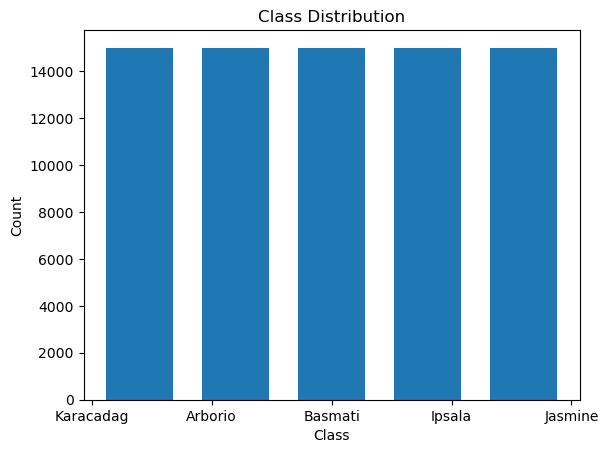

In [27]:
plt.hist(labels, bins=len(categories), align='mid', rwidth=0.7)
plt.xticks(ticks=range(len(categories)), labels=categories)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [4]:
# Normalize pixel values
data = data / 255.0

data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)

### Data Augmentation:
- The data is then augemted by **randomly flipping and rotating the image** by up to 15 degrees in either direction
- This assists in model robustness by making sure to reduce patterns found within the image taking process

In [5]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True
)

datagen.fit(data)

augmented_data = []
augmented_labels = []

for batch_data, batch_labels in datagen.flow(data, labels, batch_size=32):
    augmented_data.append(batch_data)
    augmented_labels.append(batch_labels)
    
    if len(augmented_data) * 32 >= len(data):  
        break

augmented_data = np.vstack(augmented_data)
augmented_labels = np.hstack(augmented_labels)

### Pixel Intensity Distribution
This plot shows the distribution of pixel intensity values across all images in the dataset. Pixel intensities range from **0 (black) to 255 (white)** before normalization and **0 to 1 after** (as seen in the plot).


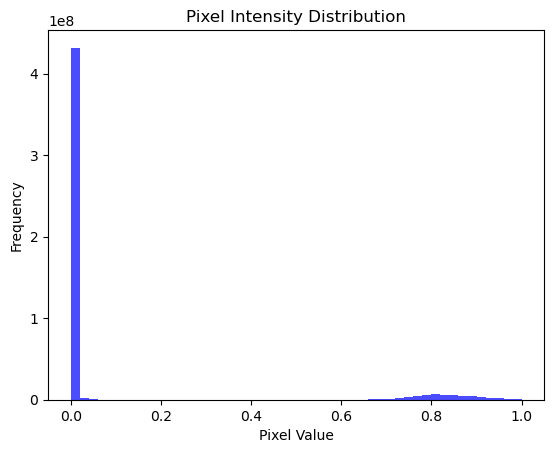

In [6]:
# Visualize pixel intensity distribution
plt.hist(data.ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

- As seen in the chart above an overwhelming amount of the pixels in the images are 0 (black).  This is because around each grain of rice is simply a black background. **Most of the data that comes from the rice itself comes from the 0.6 to 1.0 (white) range.**

#### Data Augmentation Visualization
- Below are examples of the original and augmented images.
- Augmentation techniques like rotation and flipping help **increase dataset variability** and **improve model generalization**.


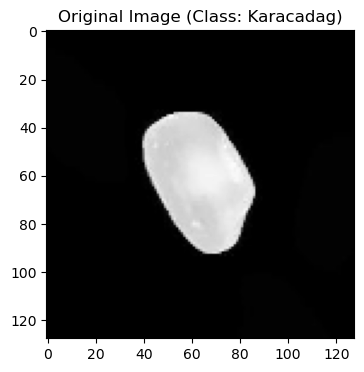

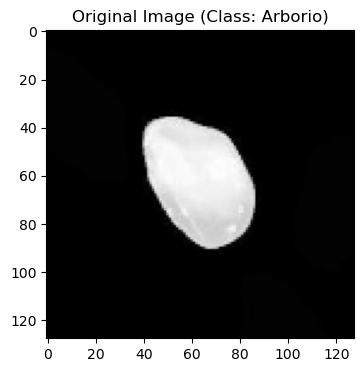

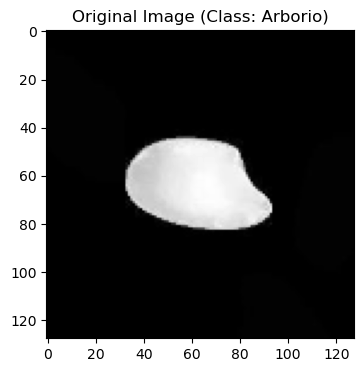

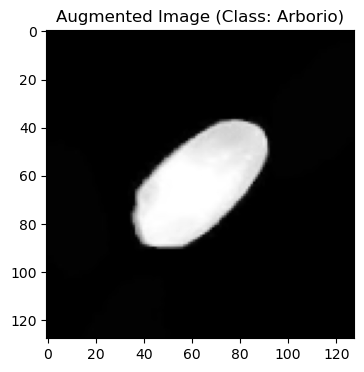

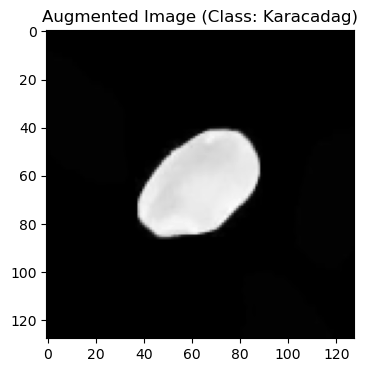

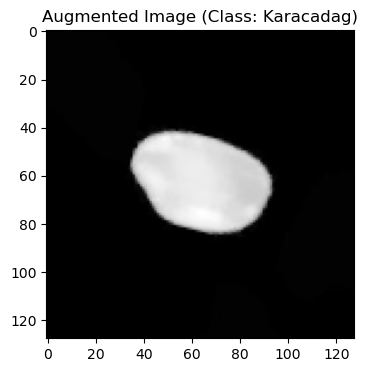

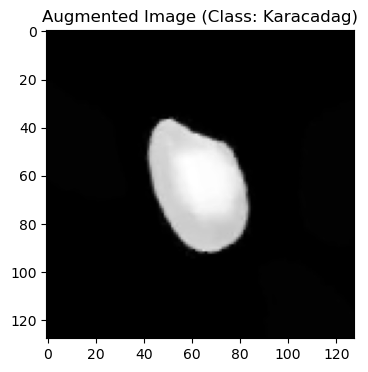

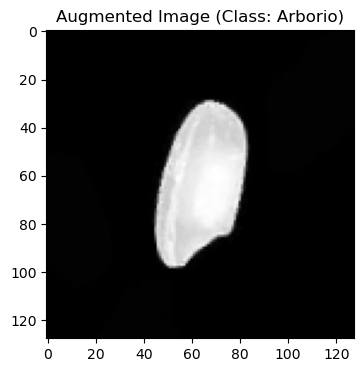

In [7]:
# Display original images
for i in range(3):
    plt.figure(figsize=(4, 4))
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.title(f"Original Image (Class: {categories[batch_labels[i]]})")
    plt.show()

# Display augmented images
for batch_data, batch_labels in datagen.flow(data, labels, batch_size=5):
    for i in range(5):
        plt.figure(figsize=(4, 4))
        plt.imshow(batch_data[i].squeeze(), cmap='gray')
        plt.title(f"Augmented Image (Class: {categories[batch_labels[i]]})")
        plt.show()
    break


#### Data Flattening
- Below the image data is flattened into 1D vectors so they can be used by logistic regression and KNN

In [8]:
# Flatten augmented images into 1D vectors
augmented_data_flattened = augmented_data.reshape(augmented_data.shape[0], -1)

#### Data Splitting
- The data is then split into **training** and **tests** sets of **80%** and **20%** of the total data respectively
- The random_state variable is also set in order to create **reproducability**.


In [9]:
# Split the Data into training and test sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(augmented_data_flattened, augmented_labels, test_size=0.2, random_state=42)

#### Logistic Regression Reasoning:
- **Logistic Regression** was chosen because it is a simple and interpretable algorithm. It works well for **linearly separable data** and provides probabilistic outputs, making it useful for binary classification tasks.

### Logistic Regression Training and Evaluation

- **Training**: The Logistic Regression model is trained on the training dataset (X_train and y_train) using the fit() method.
- **Prediction**: Predictions are made on the test dataset (X_test) using the predict() method.
- **Evaluation**: The model's performance is evaluated using classification_report, which provides metrics like precision, recall, F1-score, and support for each class.

In [10]:
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3027
           1       0.97      0.96      0.97      2973

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



#### K-NN Reasoning:
- KNN was selected because it is a distance-based algorithm. It is straightforward to implement and can capture non-linear relationships if the data is properly normalized. The hyperparameter k determines the number of neighbors used for voting, and in this project, k is determined by the below.

#### Hyperparameter Tuning for KNN:
- The performance of the KNN algorithm depends on the value of `k` (the number of neighbors). To find a better value, we use `GridSearchCV`, which performs cross-validation over a grid of `k` values. The best `k` is chosen based on the cross-validation accuracy.


In [11]:
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Perform GridSearchCV to find the best k
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Display the results
print("Best k:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best k: {'n_neighbors': 3}
Best cross-validation accuracy: 0.9685416666666666


- After tuning the k value it is then used in order to train the model

In [12]:
best_k = grid_search.best_params_['n_neighbors']
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
print("KNN Results:")
print(classification_report(y_test, y_pred_knn, target_names=categories))


KNN Results:
              precision    recall  f1-score   support

   Karacadag       0.95      0.99      0.97      3027
     Arborio       0.99      0.95      0.97      2973

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



### Dynamic Metric Calculation

This section calculates and compares the performance metrics for both Logistic Regression and KNN models. The metrics include:
- **Accuracy**: The overall correctness of the model's predictions.
- **Precision**: The proportion of correctly predicted samples for each class out of all samples predicted for that class.
- **Recall**: The proportion of correctly predicted samples for each class out of all actual samples in that class.

The calculations are performed dynamically using the actual test labels (y_test) and predictions from both models (y_pred_logistic and y_pred_knn). This ensures that the results reflect the true performance of the models on unseen data.

The metrics are presented in a table for a clear comparison between the two models, highlighting their strengths and weaknesses.


In [13]:
# Calculate metrics for both models
metrics_dynamic = {
    "Metric": ["Accuracy", "Precision (0)", "Precision (1)", "Recall (0)", "Recall (1)"],
    "Logistic Regression": [
        accuracy_score(y_test, y_pred_logistic) * 100,
        precision_score(y_test, y_pred_logistic, pos_label=0) * 100,
        precision_score(y_test, y_pred_logistic, pos_label=1) * 100,
        recall_score(y_test, y_pred_logistic, pos_label=0) * 100,
        recall_score(y_test, y_pred_logistic, pos_label=1) * 100,
    ],
    "KNN": [
        accuracy_score(y_test, y_pred_knn) * 100,
        precision_score(y_test, y_pred_knn, pos_label=0) * 100,
        precision_score(y_test, y_pred_knn, pos_label=1) * 100,
        recall_score(y_test, y_pred_knn, pos_label=0) * 100,
        recall_score(y_test, y_pred_knn, pos_label=1) * 100,
    ],
}

# Create a DataFrame for comparison
metrics_df_dynamic = pd.DataFrame(metrics_dynamic)

# Display the dynamically generated DataFrame
print(metrics_df_dynamic)

          Metric  Logistic Regression        KNN
0       Accuracy            96.666667  96.833333
1  Precision (0)            96.450871  95.218361
2  Precision (1)            96.888739  98.602864
3     Recall (0)            96.960687  98.678560
4     Recall (1)            96.367306  94.954591


### Cross-Validation:
- Cross validation helps to ensure the model is performing well by splitting the data into different **random splits** then running the algorithms again
- The accuracy scores are then averaged in order to give a more accurate depiction of model performance
- The variable **cv** is what determines how many **folds** are being run.

In [14]:
# Cross-validation for Logistic Regression
logistic_scores = cross_val_score(logistic_model, X_train, y_train, cv=5)
print("Cross-validation scores for Logistic Regression:", logistic_scores)
print("Mean accuracy for Logistic Regression:", np.mean(logistic_scores))

# Cross-validation for KNN
knn_scores = cross_val_score(knn_model, X_train, y_train, cv=5)
print("Cross-validation scores for KNN:", knn_scores)
print("Mean accuracy for KNN:", np.mean(knn_scores))


Cross-validation scores for Logistic Regression: [0.96625    0.968125   0.96395833 0.96875    0.95979167]
Mean accuracy for Logistic Regression: 0.9653750000000001
Cross-validation scores for KNN: [0.97083333 0.96875    0.966875   0.97208333 0.96416667]
Mean accuracy for KNN: 0.9685416666666666


### Cross-Validation Results
- Cross-validation ensures the models generalize well to unseen data by training and testing on different splits of the dataset (otherwise known as folds).
- The **mean accuracy** for Logistic Regression and KNN across **5 folds** was:
- **Logistic Regression: 96.54%**
- **KNN: 96.85%**


### Example data results

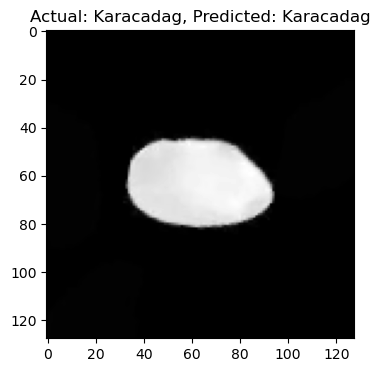

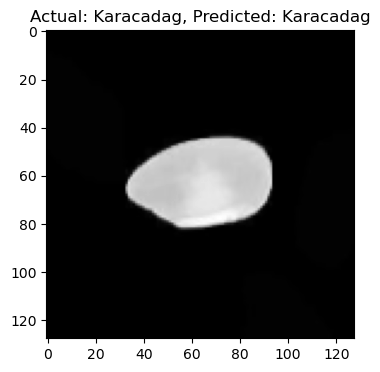

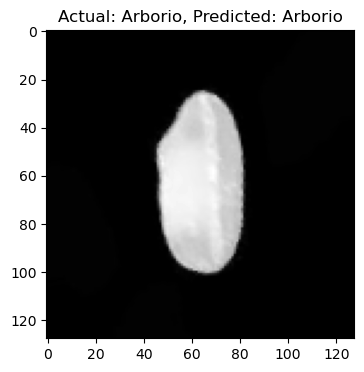

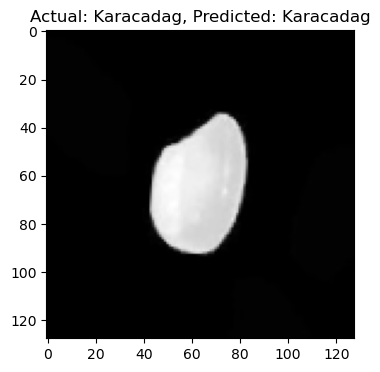

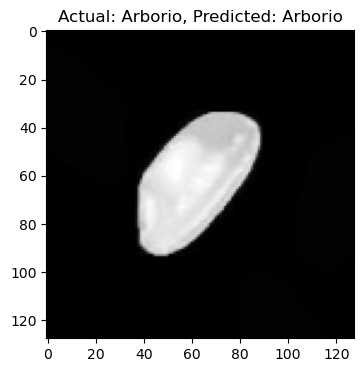

In [15]:
for i in range(5):
    plt.figure(figsize=(4, 4))
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.title(f"Actual: {categories[y_pred_knn[i]]}, Predicted: {categories[y_test[i]]}")
    plt.show()

### Confusion matrix and Misclassification examples for k-NN

### Importance of Confusion Matrix:

- **Error Analysis**: Misclassifications can be analyzed directly from the confusion matrix, allowing you to pinpoint which classes are being confused (squares in purple are misclassifications).
- **Interpretability**: Unlike single metrics like accuracy, the confusion matrix gives a more interpretable view of the model's predictions across all categories.


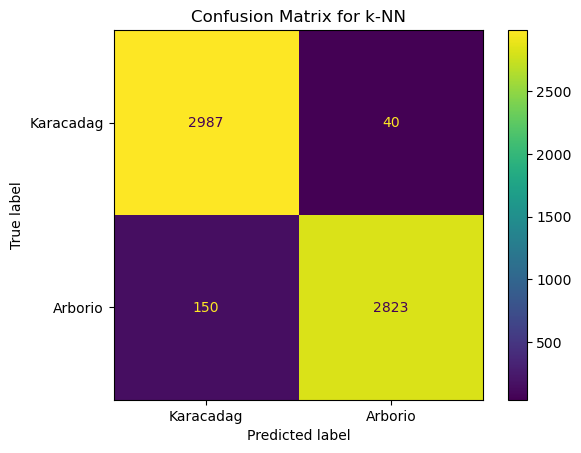

In [16]:
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot()
plt.title("Confusion Matrix for k-NN")
plt.show()


### Misclassified Samples for k-NN

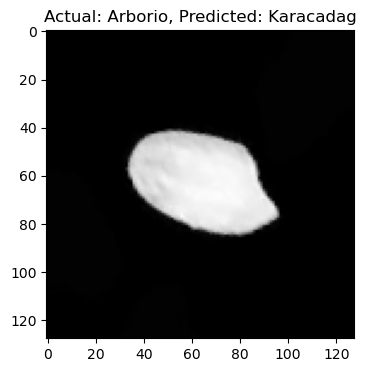

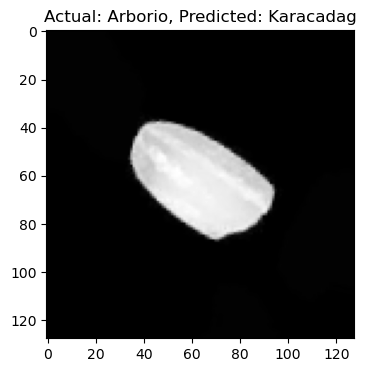

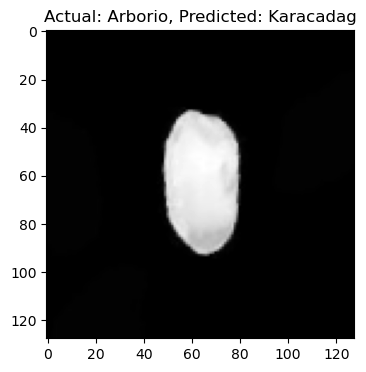

In [17]:
# Display 3 misclassified samples
misclassified_count = 0 
max_misclassified = 3    # Maximum number images to display

for i in range(len(y_test)):
    if y_test[i] != y_pred_knn[i]:  # Check if the prediction is incorrect
        plt.figure(figsize=(4, 4))
        plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
        plt.title(f"Actual: {categories[y_test[i]]}, Predicted: {categories[y_pred_knn[i]]}")
        plt.show()
        misclassified_count += 1  # Increment the counter
        
        if misclassified_count == max_misclassified:
            break


### Confusion matrix and Misclassification examples for Logistic Regression

### Importance of Confusion Matrix in This Context
- **Error Analysis**: Misclassifications can be analyzed directly from the confusion matrix, allowing you to pinpoint which classes are being confused (squares in purple are misclassifications).
- **Interpretability**: Unlike single metrics like accuracy, the confusion matrix gives a more interpretable view of the model's predictions across all categories.


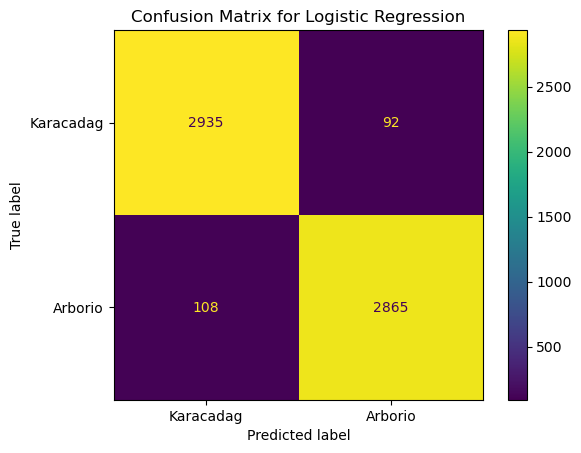

In [18]:
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=categories)
disp_logistic.plot(cmap='viridis')
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

### Misclassified Samples for Logistic Regression

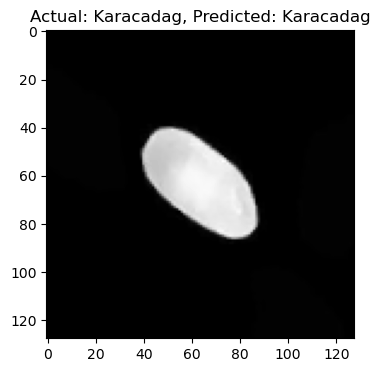

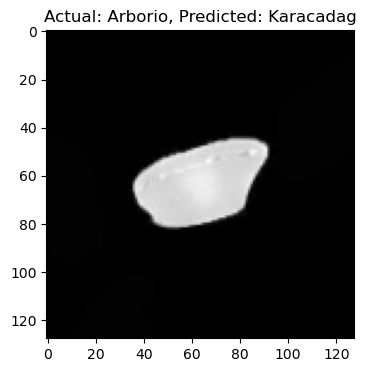

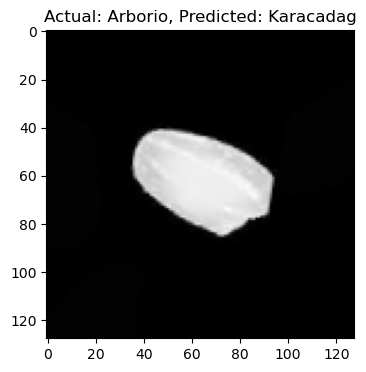

In [19]:
# Display 3 misclassified samples
misclassified_count = 0 
max_misclassified = 3    # Maximum number images to display

for i in range(len(y_test)):
    if y_test[i] != y_pred_logistic[i]:  # Check if the prediction is incorrect
        plt.figure(figsize=(4, 4))
        plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
        plt.title(f"Actual: {categories[y_test[i]]}, Predicted: {categories[y_pred_knn[i]]}")
        plt.show()
        misclassified_count += 1  # Increment the counter
        
        if misclassified_count == max_misclassified:
            break


### Reasoning for Misclassifictions
- Most misclassifications happen as misclassified samples often exhibit **overlapping pixel patterns** between the two rice varieties
- Another reason some misclassifications may be happening is **data loss** from image resizing and turning into grayscale

### Importance of the ROC Curve

- **Model Evaluation**: The ROC curve evaluates the model's ability to distinguish between the two different classes
- **AUC Score**: The AUC provides a single scalar value to measure the model's overall performance. A higher AUC indicates better classification ability.
- **Interpretability**: The curve visually illustrates the model's discriminative power, making it easy to understand.



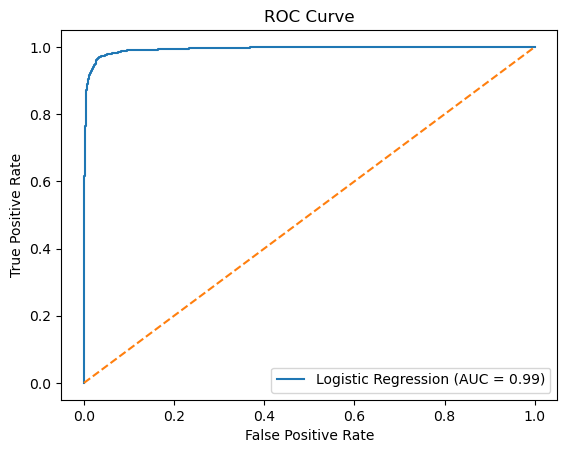

In [20]:
y_probs_logistic = logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs_logistic)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Conclusion
- This project successfully classified rice varieties using Logistic Regression and KNN.
- KNN slightly outperformed Logistic Regression, showing its ability to capture non-linear relationships.
- These results demonstrate the potential for automating quality control processes in agriculture. Another possible application of this is for seed sorting and identification.
- Future work could involve testing more advanced models like CNNs or applying the pipeline to multi-class classification with all five rice varieties.

## Implementation of multi-class classification

### Setup of MultiClass image classification:
- The logic below is the same as the original binary classification task but this time we are utilizing **all five** data categories
- This means **all 75,000** images in the dataset will be used

In [21]:
categories = ["Karacadag", "Arborio", "Basmati", "Ipsala", "Jasmine"]

data = []
labels = []

for category in categories:
    folder_path = os.path.join(data_dir, category)
    class_label = categories.index(category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            data.append(img)
            labels.append(class_label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

# Convert to numpy arrays
data = np.array(data) / 255.0
labels = np.array(labels)

### Data augmentation:
- Data is once again augmented in order to help the robustness of the model and to prevent overfitting to non rice-specific data

In [22]:
data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)

datagen = ImageDataGenerator(
    rotation_range=15, 
    horizontal_flip=True,
)

datagen.fit(data)

augmented_data = []
augmented_labels = []

for batch_data, batch_labels in datagen.flow(data, labels, batch_size=32):
    augmented_data.append(batch_data)
    augmented_labels.append(batch_labels)
    
    if len(augmented_data) * 32 >= len(data):  
        break

augmented_data = np.vstack(augmented_data)
augmented_labels = np.hstack(augmented_labels)

### Data Splitting:
- Data is then split into training and test sets 80% and 20% of the data respectively

In [23]:
X_train, X_test, y_train, y_test = train_test_split(augmented_data, augmented_labels, test_size=0.2, random_state=42, stratify=augmented_labels)

In [24]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

KNeighborsClassifier(n_neighbors=3)

### Multiclass k-NN results:

In [25]:
y_pred_knn = knn_model.predict(X_test.reshape(X_test.shape[0], -1))
print("KNN Results:")
print(classification_report(y_test, y_pred_knn, target_names=categories))

KNN Results:
              precision    recall  f1-score   support

   Karacadag       0.95      0.98      0.97      3000
     Arborio       0.98      0.94      0.96      3000
     Basmati       0.97      0.98      0.98      3000
      Ipsala       1.00      0.99      1.00      3000
     Jasmine       0.97      0.97      0.97      3000

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000



- The above results show a **> 95% accuracy, recall, and f1-score** which indicates good model performance

### Confusion Matrix for MultiClass k-NN

### Importance of Confusion Matrix in This Context
- **Error Analysis**: Misclassifications can be analyzed directly from the confusion matrix, allowing you to pinpoint which classes are being confused (squares in purple are misclassifications).
- **Interpretability**: Unlike single metrics like accuracy, the confusion matrix gives a more interpretable view of the model's predictions across all categories.

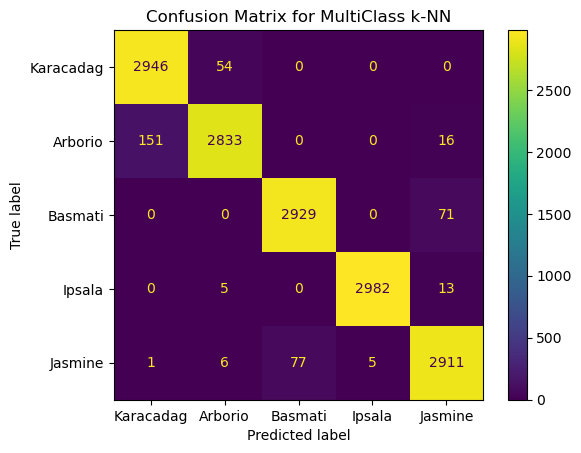

In [26]:
cm = confusion_matrix(y_test, y_pred_knn)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='viridis')  # Use your preferred colormap
plt.title("Confusion Matrix for MultiClass k-NN")
plt.show()

- The above showcases that k-NN can be used on this dataset and scale very easily
- This allows for identification and classification of more rice types given they are added to the dataset

### References
- Koklu, Murat. "Rice Images Dataset." Kaggle, https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset.
- Scikit-learn: Machine Learning in Python. https://scikit-learn.org/stable/.
- Matplotlib: Visualization with Python. https://matplotlib.org/.
- TensorFlow: Machine Learning for Everyone. https://www.tensorflow.org/.
